# NEOExchange Observations Planner
**Developer:** Aayushi Verma

**Aim**: this code outputs an object visibility chart, similar to StarAlt (http://catserver.ing.iac.es/staralt/), and an alt-az chart.

This code is optimised to be used for NEOExchange objects (https://neoexchange.lco.global/), however can be used for any astronomical object at any observatory.

In [1]:
#importing useful packages
import numpy as np
import matplotlib.pyplot as plt
#---
from astropy import units as u
from astropy.time import Time
from astropy.table import Table
from astropy.coordinates import get_sun, get_moon, SkyCoord, EarthLocation, AltAz
#---
from astroplan import plots, observability_table
from astroplan import Observer, FixedTarget
from astroplan import AltitudeConstraint, AirmassConstraint, AtNightConstraint
from astroplan import is_observable, is_always_observable, months_observable
#---
from astroquery.jplhorizons import Horizons
#---
import os
import pytz

## 1. Input your observation session parameters here.

First, enter observation time parameters.

In [2]:
# specify your timezone in UTC
utc_offset = +13 * u.hour  # New Zealand Daylight Savings Time

# define observation dates to show on object visibility plots
obs_dates_display = '1/3 - 8/3'
obs_dates_save = '1-8Mar'

# enter the start and end dates of your observing run
obs_start_date   = '2021-03-01'   #YYYY-MM-DD
obs_end_date     = '2021-03-08'   #YYYY-MM-DD

# enter the start and end time of your night
night_start_time = '21:00:00'     #HH:MM:SS
night_end_time   = '07:00:00'     #HH:MM:SS

Next, input your list of targets. 
* `targets_file` - This should be a `.txt` text file with the names of your targets. See the sample targets file, `sample_targets.txt`, for formatting. Ensure the target names are as specific as possible, otherwise an error will be thrown. These targets are queried on the JPL Horizons database (https://ssd.jpl.nasa.gov/horizons.cgi), so if in doubt, check your object on the database first.
* `epoch_dates` - Enter the start and stop dates in YYYY-MM-DD format, and change the step interval you require.

In [3]:
# enter the name of the targets list
# targets_file = "mar_week1_obs_targets1.txt"
targets_file = "sample_targets.txt"

In [4]:
# enter observation run dates and the time interval you need data for 
# generally you won't need to change the start and stop times, but change the step time if you need to
epoch_dates = {'start':obs_start_date, 'stop':obs_end_date,'step':'15m'} #YYYY-MM-DD

Here, define the observation location parameters. Edit the latitude, longitude and elevation for your observatory. Also enter the location code for your observatory (https://minorplanetcenter.net//iau/lists/ObsCodesF.html).

In [5]:
# defining the observing location parameters
latitude = -43.29 * u.deg
longitude = 170.27 * u.deg
elevation = 1029 * u.m

# enter the location code of your observatory
obs_location_code = 474

In [6]:
# defining the limiting altitude of the telescope, i.e. the minimum altitude possible.
lim_alt = 30 #degrees

In [7]:
# setting observing constraints

# altitude range of the telescope
min_alt = 30 * u.deg
max_alt = 90 * u.deg

# max airmass allowed
max_airmass = 5

# your definition of nighttime period for your observations
# by default we will take this to be between civil twilights
# change if needed
nighttime = AtNightConstraint.twilight_civil()

## 2. The following code will provide useful information for your observation session.

Run the code, no need to change anything.

In [8]:
# reading in the targets list file
target_names = []
with open(targets_file, "r") as file:
    for line in file: 
        line = line.strip("\n") 
        target_names.append(line) 
file.close()

In [9]:
# defining the time range of the observation period
obs_start_time = str(obs_start_date+' '+night_start_time)
obs_start_time = Time(obs_start_time) - utc_offset 

obs_end_time = str(obs_end_date+' '+night_end_time) 
obs_end_time = Time(obs_end_time) - utc_offset  

midnight = str(obs_end_date+' '+'00:00:00')   
midnight = Time(midnight) - utc_offset      

In [10]:
# Specify the location of your observatory:
obs_location = EarthLocation.from_geodetic(longitude, latitude, elevation)

# Make an observer at your observatory:
observatory = Observer(location=obs_location)

# making time range of osbervation period
obs_time_range = Time([obs_start_time, obs_end_time])

In [11]:
# querying the JPL Horizons database for RA/DEC, airmass, Alt/Az, and magnitude information for your targets
target_info = []
for target_name in target_names:
    obj = Horizons(id=target_name,location=obs_location_code,epochs=epoch_dates)
    obj_data = obj.ephemerides(skip_daylight=True)
    JPLtableData = obj_data['targetname','datetime_jd','datetime_str','RA','DEC','airmass','AZ','EL']
    target_info.append(JPLtableData)

In [12]:
# generating SkyCoord and FixedObject objects for your targets for calculation purposes
fixed_targets_lst = []
skycoord_targets_lst = []

for target in target_info:
    target_name = target['targetname']
    my_ra = target['RA']
    my_dec = target['DEC']
    jd_times = target['datetime_jd']
    obs_time_jd = Time(jd_times,format='jd',scale='utc')

    # making SkyCoord object
    c = SkyCoord(ra=my_ra,dec=my_dec,unit=(u.hourangle,u.deg),obstime=obs_time_jd)
    skycoord_targets_lst.append(c)
    
    # making FixedObject object
    fixed_target = FixedTarget(coord=c,name=target_name)
    fixed_targets_lst.append(fixed_target)

In [13]:
# defining midnight for calculation purposes
delta_midnight = np.linspace(-12, 12, len(skycoord_targets_lst[0])) * u.hour 
times = midnight + delta_midnight

# creating an Alt/Az frame for calculation purposes
altazframe = AltAz(obstime=times, location=obs_location)

# finding the Alt/Az information for the Sun and Moon
sunaltazs = get_sun(times).transform_to(altazframe)
moonaltazs = get_moon(times).transform_to(altazframe)

# finding the Alt/Az information for your targets
target_altazs = []
for target in skycoord_targets_lst:
    target_altazs.append(target.transform_to(altazframe))

In [14]:
# calculations for Target Position Plot
dt = obs_time_range[1] - obs_time_range[0]
target_position_plot_times = obs_time_range[0] + dt * np.linspace(0,1,len(skycoord_targets_lst[0]))

In [15]:
# # making an observability table

# # changing directory to TargetInfo subfolder
# #os.chdir("C://Users//aayus//OneDrive - University of Canterbury//ASTR391 Research Project//Code//Obs Planning Code//NEOExchange-Observations-Planner//TargetInfo/")
# os.chdir("C://Users//ave41//OneDrive - University of Canterbury//ASTR391 Research Project//Code//Obs Planning Code//NEOExchange-Observations-Planner//TargetInfo/")

# for i in range(len(target_info)):
#     obs_table = Table()
#     obs_table['Target'] = target_info[i]['targetname']
#     obs_table['Date/Time'] = target_info[i]['datetime_str']
#     obs_table['RA'] = target_info[i]['RA']
#     obs_table['DEC'] = target_info[i]['DEC']
#     obs_table['Airmass'] = target_info[i]['airmass']
#     obs_table['Altitude'] = target_info[i]['EL']
# #     obs_table['Magnitude'] = target_info[i]['Tmag']
#     obs_table.write('{}.html'.format(i),format='jsviewer')
    
# # changing directory back to main folder
# os.chdir("C://Users//ave41//OneDrive - University of Canterbury//ASTR391 Research Project//Code//Obs Planning Code//NEOExchange-Observations-Planner")
# # os.chdir("C://Users//aayus//OneDrive - University of Canterbury//ASTR391 Research Project//Code//Obs Planning Code//NEOExchange-Observations-Planner")

## 3. Object Visibility Plot!

Run the code to obtain your object visibility plot.

In [16]:
# making a zero-line for the limiting alitude of your telescope
zeroLine_x1=np.arange(-12,90,10)
zeroLine_y1=np.full(len(zeroLine_x1),lim_alt)

# making a warning zero-line for the limiting alitude of your telescope
zeroLine_y2=np.full(len(zeroLine_x1),lim_alt+10)

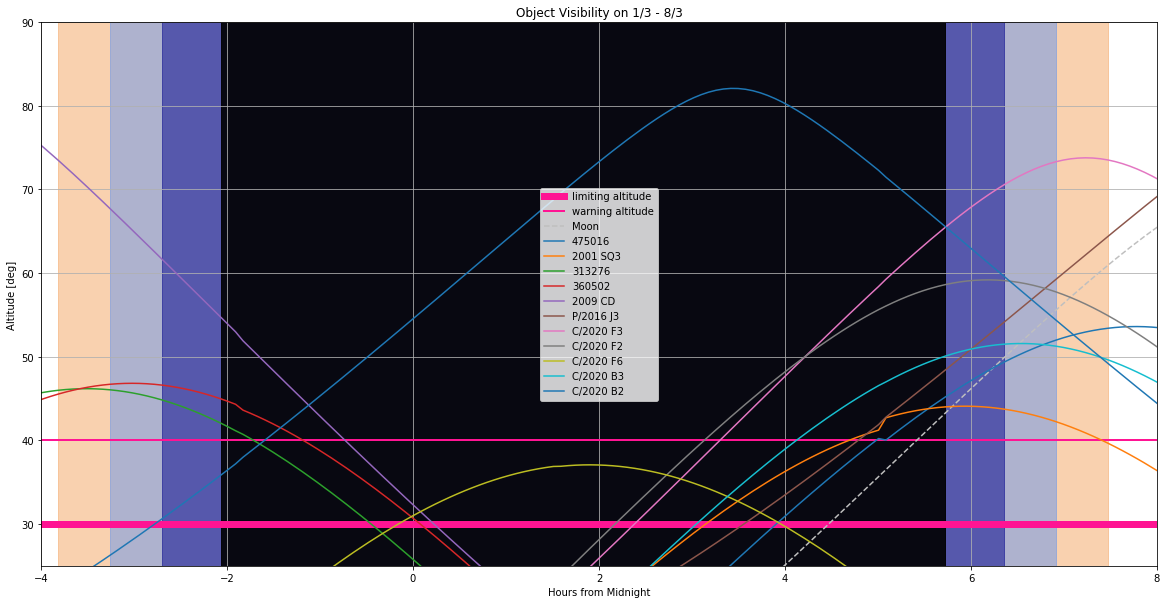

In [17]:
# Altitude Plot

# changing directory to Plots subfolder
# os.chdir("C://Users//aayus//OneDrive - University of Canterbury//ASTR391 Research Project//Code//Obs Planning Code//NEOExchange-Observations-Planner//Plots/")
os.chdir("C://Users//ave41//OneDrive - University of Canterbury//ASTR391 Research Project//Code//Obs Planning Code//NEOExchange-Observations-Planner//Plots/")

plt.figure(figsize=(20,10))
plt.plot(zeroLine_x1,zeroLine_y1,"-",linewidth=7,color="deeppink",label="limiting altitude")
plt.plot(zeroLine_x1,zeroLine_y2,"-",linewidth=2,color="deeppink",label="warning altitude")
plt.plot(delta_midnight, moonaltazs.alt, color=[0.75]*3, ls='--', label='Moon')

# plotting the alitudes of the objects
for i in range(len(target_altazs)):  
#     plt.scatter(delta_midnight,target_altazs[i].alt,label='{}'.format(target_names[i]), lw=0, s=8) 
    plt.plot(delta_midnight,target_altazs[i].alt,label='{}'.format(target_names[i])) 

# defining twilight/nighttimes
# plt.fill_between(delta_midnight, 0, 90, sunaltazs.alt < -0*u.deg, color='0.5', zorder=0)  
# plt.fill_between(delta_midnight, 0, 90, sunaltazs.alt < -18*u.deg, color='k', zorder=0)   
plt.fill_between(delta_midnight, 0, 90, sunaltazs.alt < -0*u.deg, color='sandybrown', zorder=0, alpha = 0.5)  
plt.fill_between(delta_midnight, 0, 90, sunaltazs.alt < -6*u.deg, color='cornflowerblue', zorder=0, alpha = 0.5) 
plt.fill_between(delta_midnight, 0, 90, sunaltazs.alt < -12*u.deg, color='darkblue', zorder=0, alpha = 0.5)  
plt.fill_between(delta_midnight, 0, 90, sunaltazs.alt < -18*u.deg, color='k', zorder=0, alpha = 0.9)  

plt.legend()
plt.xlim(-4, 8)          #can change this as appropriate, it is the number of hours before and after midnight (ie on your x-axis)
plt.ylim(lim_alt-5, 90)  #could range from 0-90 degrees
plt.xlabel('Hours from Midnight')  
plt.ylabel('Altitude [deg]')  
plt.title("Object Visibility on {}".format(obs_dates_display))
plt.grid()
plt.savefig('TargetVisibility_{}.png'.format(obs_dates_save))
plt.show()

# changing directory back to main folder
os.chdir("C://Users//ave41//OneDrive - University of Canterbury//ASTR391 Research Project//Code//Obs Planning Code//NEOExchange-Observations-Planner")
# os.chdir("C://Users//aayus//OneDrive - University of Canterbury//ASTR391 Research Project//Code//Obs Planning Code//NEOExchange-Observations-Planner")

In [18]:
# # Altitude/Azimuth Plot
# for i in range(len(target_altazs)):
# #     os.chdir("C://Users//ave41//OneDrive - University of Canterbury//ASTR391 Research Project//Code//Obs Planning Code//NEOExchange-Observations-Planner")
#     # plotting
#     plt.figure() #figsize=(20,10)
#     plt.plot(zeroLine_x1,zeroLine_y1,"-",linewidth=7,color="deeppink")
#     plt.plot(zeroLine_x1,zeroLine_y2,"-",linewidth=2,color="deeppink")
#     plt.plot(delta_midnight, moonaltazs.alt, color=[0.75]*3, ls='--', label='Moon')

#     # plotting the alitudes of the objects
#     plt.scatter(delta_midnight,target_altazs[i].alt,c=target_altazs[i].az, lw=0, s=8)
#     #plt.plot(delta_midnight,target_altazs[i].alt,label='{}'.format(target_names[i])) 
#     plt.colorbar().set_label('Azimuth [deg]') 
    
#     # defining twilight/nighttimes
#     plt.fill_between(delta_midnight, 0, 90, sunaltazs.alt < -0*u.deg, color='0.5', zorder=0)  
#     plt.fill_between(delta_midnight, 0, 90, sunaltazs.alt < -18*u.deg, color='k', zorder=0)   

#     #plt.legend()
#     plt.xlim(-4, 7)          #can change this as appropriate, is basically the number of hours before and after midnight (ie on your x-axis)
#     plt.ylim(lim_alt-5, 90)  #could range from 0-90 degrees
#     plt.xlabel('Hours from Midnight')  
#     plt.ylabel('Altitude [deg]')  
#     plt.title("Visibility of {} on {}".format(target_names[i],obs_dates_display))
#     plt.grid()
# #     os.chdir("Plots/")
# #     plt.savefig('{}.png'.format(my_targets[i][0]+'-'+obs_dates_save))
#     plt.show()

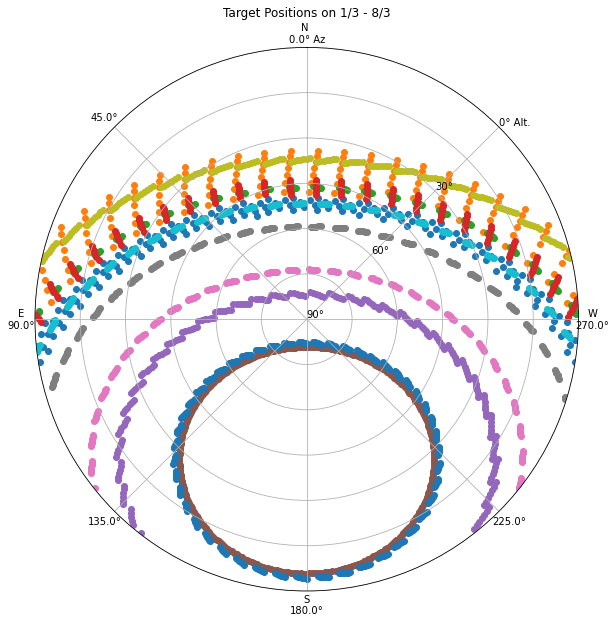

In [19]:
# Target Position Plot

# changing directory to Plots subfolder
os.chdir("Plots/")

plt.figure(figsize=(10,10))
for target in fixed_targets_lst:
    plots.plot_sky(target, observatory, target_position_plot_times)
plt.title("Target Positions on {}".format(obs_dates_display))
# plt.legend()
plt.savefig('TargetPositions_{}.png'.format(obs_dates_save))
plt.show()

# changing directory back to main folder
os.chdir("C://Users//ave41//OneDrive - University of Canterbury//ASTR391 Research Project//Code//Obs Planning Code//NEOExchange-Observations-Planner")
# os.chdir("C://Users//aayus//OneDrive - University of Canterbury//ASTR391 Research Project//Code//Obs Planning Code//NEOExchange-Observations-Planner")